# Generative adversarial networks (GANs)

Let $\mathcal{D}=\{x_i\}_{i=1}^N\subset X = \mathbb{R}^n$ be a dataset we want to be able to "mimic" samples from.


Neural networks:
* Let $D : X \to \mathbb{R}$ be a neural net, the so called discriminator.
* Let $G : Z = \mathbb{R}^m \to X$ be a neural net, the so called generator.

Probability distributions:
* Let $p_X$ be the distibution that generated $\mathcal{D}$'s samples.
* Let $p_G$ be the distibution that we generate if we apply $G$ to samples from $\mathcal{N}(0, \mathbb{1}_k)$.
    + I.e., we can sample $\hat x \sim p_G$ by sampling $z\sim\mathcal{N}(0, \mathbb{1})$ and computing $G(z)$.

The goal is that we train $G$ such that we approximate

$$p_X = p_G.$$

* Idea: pick some distance measure $d$ between probabiltiy distributions and try to find a $G$ that "solve"

$$\min_G d(p_X, p_G).$$

* In practice it is hard to compute these distances for general probability distributions.
    + We saw an exception with the KL-divergences between Gaussians in the case of VAEs.

## Different distances
### Original GAN (2014 [paper](https://arxiv.org/abs/1406.2661))

The original GAN used the Jensen–Shannon divergence.

If we assume a function $D:X\to [0,1]$, we can define the JS divergence as

$$d(p_X, p_G) = \max_D \mathbb{E}_{x\sim p_X} \log D(x) + \mathbb{E}_{\hat x\sim p_G} \log\left[1- D(\hat x)\right].$$

We can view $D$ as a BCE classifier that tires to predict whether a sample is "real" or generated.
I.e., $D$ should have high values for real $x$ -- this is the case for all GANs, except the Wasserstein GAN.

### Wasserstein GAN (WGAN) (2017 [paper](https://arxiv.org/abs/1701.07875))

* Uses the Wasserstein distance.

* Defined via a 1-Lipschitz $D:X\to \mathbb{R}$ as

$$d(p_X, p_G) = \max_D \mathbb{E}_{x\sim p_G} D(X) - \mathbb{E}_{x\sim p_X} D(X).$$

* Here the discriminator is often called a "critic."

## GAN training

* One needs to solve a minimax problem/game. E.g., for the JS divergence

$$\min_G d(p_X, p_G) = \min_G \max_D \mathbb{E}_{x\sim p_X} \log D(x) + \mathbb{E}_{z\sim \mathcal{N}(0,\mathbb{1})} \log\left[1- D(G(z))\right].$$

* Often a tricky and unstable process.
* Usual approach:
    1. SGD step on $D$'s  parameters via $L_D$.
    2. SGD step on $G$'s parameters via $L_G$.
    3. Go to 3 unless happy with training result.

I.e., we pin $D$ and $G$ against each other in a minimax game.

### Examples

For the **JS divergence** we have

$$L_D = -\mathbb{E}_{x\sim p_X} \log D(x) - \mathbb{E}_{z\sim \mathcal{N}(0,\mathbb{1})} \log\left[1- D(G(z))\right]$$

and

$$L_G = \mathbb{E}_{z\sim \mathcal{N}(0,\mathbb{1})} \log\left[1- D(G(z))\right].$$

For the **WGAN** we define

$$L_D = \mathbb{E}_{x\sim p_X} D(x) - \mathbb{E}_{z\sim \mathcal{N}(0,\mathbb{1})} D(G(z)) + \lambda \mathbb{E}_{z\sim \mathcal{N}(0,\mathbb{1}), x\sim p_X, \alpha\sim U[0, 1]} \text{ReLU}\left(\|(\nabla D)(\alpha x + (1-\alpha)G(z))\|_2^2 - 1\right)^2$$

and

$$L_G = \mathbb{E}_{z\sim \mathcal{N}(0,\mathbb{1})} D(G(z)).$$

I.e., for the WGAN's $L_D$ we add a penalty term that encourages the norm of the gradient of $D$ with respect to its input to not exceed $1$. This encourages the $1$-Lipschitz condition to be meet sufficiently for the optimization to work.

## Exceptions

* $\exists$ GANs that are exceptions to the distance formulation.
    + I.e., $D$ and $G$ have irreconcilable losses.
* But conceptually they tend to be close the distance formulation.

### Least squares GAN (2017 [paper](https://arxiv.org/abs/1611.04076))

Here we have $D:X\to \mathbb{R}$ or at least $D:X\to [-1,1]$ and

$$L_D = \mathbb{E}_{x\sim p_X} (D(x) - b)^2 + \mathbb{E}_{z\sim \mathcal{N}(0,\mathbb{1})} (D(G(z)) - a)^2$$

and

$$L_G = \mathbb{E}_{z\sim \mathcal{N}(0,\mathbb{1})} (D(G(z)) - c)^2$$

with $a=-1$, $b=1$, and $c=0$.

### Hinge loss GAN (2017 [paper](https://arxiv.org/abs/1705.02894))

* Note: Also called geometric GAN.

Here we have

$$L_D = -\mathbb{E}_{x\sim p_X} \min(0, D(x) - 1) - \mathbb{E}_{z\sim \mathcal{N}(0,\mathbb{1})} \min(0, -(D(x) + 1))$$

and

$$L_G = -\mathbb{E}_{z\sim \mathcal{N}(0,\mathbb{1})} D(G(z)).$$

## Example of a GAN training

We first load MNIST as our training data and write some boilerplate code.

In [1]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

import logging
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

logging.getLogger('matplotlib.font_manager').disabled = True
plt.xkcd()

train_data = MNIST(
    root = 'datasets',
    train = True,
    transform = ToTensor(),
    download = True,
)

print(f"Training data shape: {tuple(train_data.data.shape)}")

Training data shape: (60000, 28, 28)


In [2]:
batch_size = 128

data_loader_train = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
)

In [3]:
def plot_first8_images(xs):
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(xs[i].squeeze(), cmap="gray")
        plt.xticks([])
        plt.yticks([])

    plt.gcf().set_size_inches(15, 5)
    plt.show()


def plot_losses(losses_D, losses_G):
    plt.plot(losses_D, label="losses_D")
    plt.plot(losses_G, label="losses_G")
    plt.gcf().set_size_inches(10, 4)
    plt.legend()
    plt.show()

In [4]:
class UnFlatten(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape


    def forward(self, xs):
        return xs.reshape(len(xs), *self.shape)

We initalize some simple networks for $G$ and $D$.

In [5]:
G = nn.Sequential(
    nn.Linear(64, 8*7*7),
    nn.ReLU(),
    UnFlatten([8, 7, 7]),
    nn.LayerNorm(normalized_shape=[8, 7, 7]),

    nn.UpsamplingNearest2d(size=[14, 14]),
    nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.LayerNorm(normalized_shape=[8, 14, 14]),

    nn.UpsamplingNearest2d(size=[28, 28]),
    nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.LayerNorm(normalized_shape=[8, 28, 28]),

    nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.LayerNorm(normalized_shape=[8, 28, 28]),

    nn.Conv2d(in_channels=8, out_channels=1, kernel_size=3, padding=1),
    nn.Sigmoid(),
)

D =  nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.LayerNorm(normalized_shape=[8, 14, 14]),

    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.LayerNorm(normalized_shape=[16, 7, 7]),

    nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.LayerNorm(normalized_shape=[16, 4, 4]),

    nn.Flatten(),
    nn.Linear(16*4*4, 64),
    nn.ReLU(),

    nn.LayerNorm(normalized_shape=[64]),
    nn.Linear(64, 1),
    nn.Tanh(),
)

We use the Least Squres losses.

In [6]:
def LD_LS(D, x, x_hat, a=-1, b=1):
    losses = (D(x) - b)**2 + (D(x_hat) - a)**2
    return losses.mean()


def LG_LS(D, x, x_hat, c=0):
    losses = (D(x_hat) - c)**2
    return losses.mean()

We inialize some objects for the training. We use Adam with a lower than usual first momentum, to smooth the training by making it slower.

In [7]:
β1, β2 = .9, .999
optimizer_D = torch.optim.Adam(D.parameters(), lr=1e-3, betas=(β1, β2))
optimizer_G = torch.optim.Adam(G.parameters(), lr=1e-3, betas=(β1, β2))

n_epochs = 8

losses_D_train = []
losses_G_train = []

We train $G$ and $D$ and plot the intermediate results.

  0%|          | 0/8 [00:00<?, ?it/s]

After epoch 0:


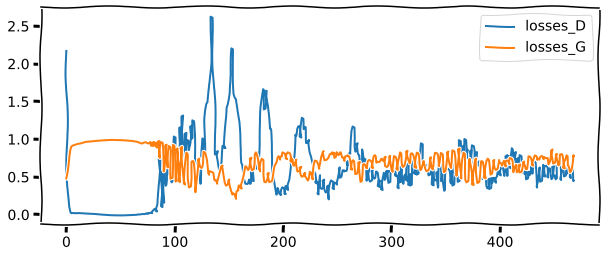

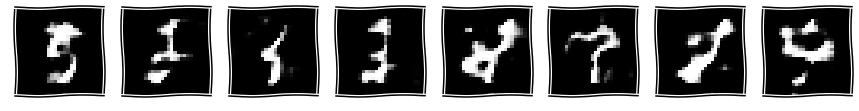

After epoch 1:


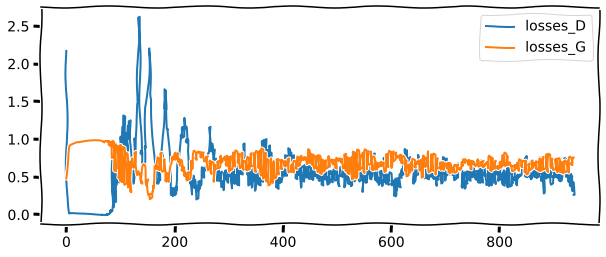

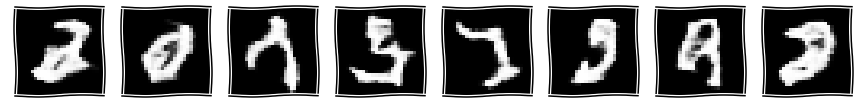

After epoch 2:


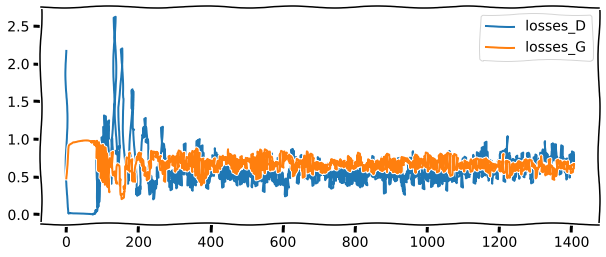

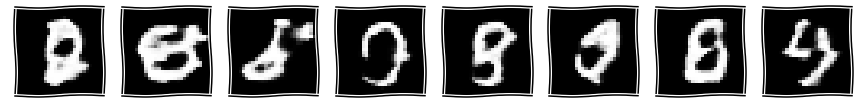

After epoch 3:


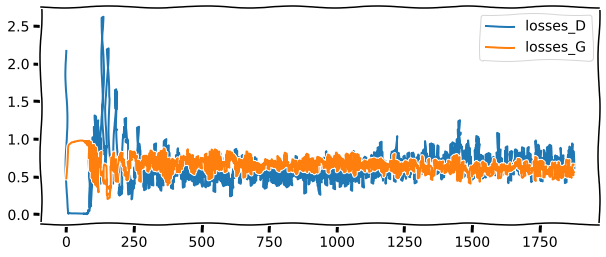

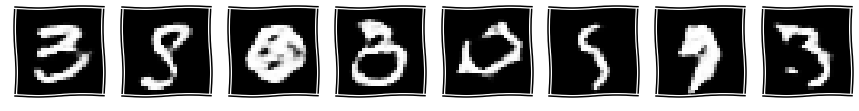

After epoch 4:


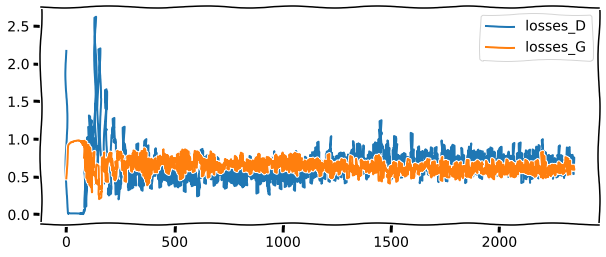

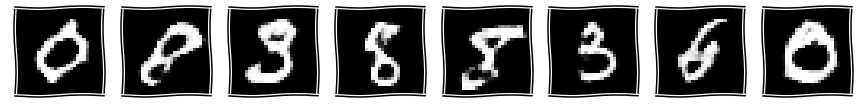

After epoch 5:


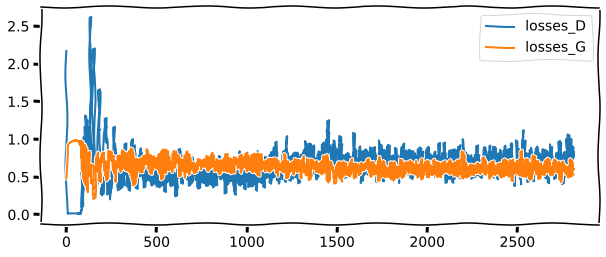

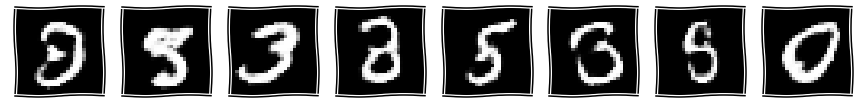

After epoch 6:


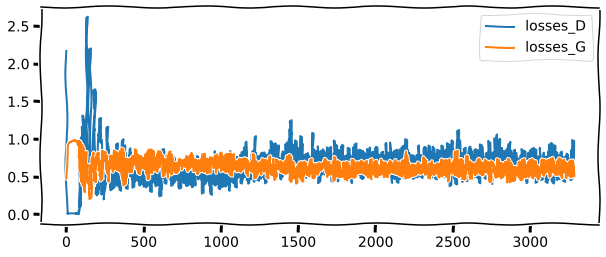

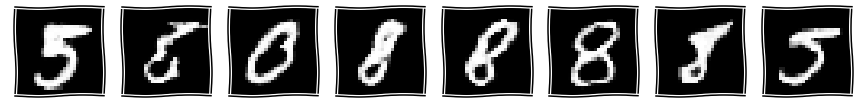

After epoch 7:


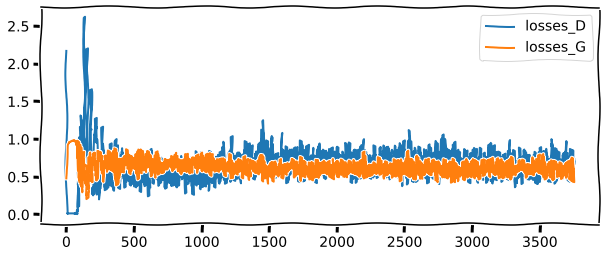

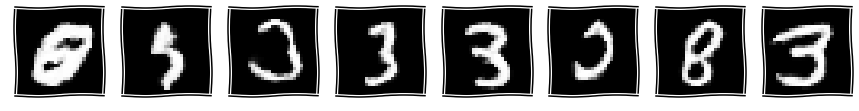

In [8]:
for epoch in tqdm(range(n_epochs)):
    D.train()
    G.train()

    for xs, ys in data_loader_train:
        batch_size = len(xs)

        zs = torch.randn(batch_size, 64)
        xs_hat = G(zs)


        loss_D = LD_LS(D, xs, xs_hat)
        losses_D_train.append(loss_D.item())

        optimizer_D.zero_grad()
        loss_D.backward(retain_graph=True)
        optimizer_D.step()


        loss_G = LG_LS(D, xs, xs_hat)
        losses_G_train.append(loss_G.item())

        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()


    print(f"After epoch {epoch}:")
    plot_losses(losses_D_train, losses_G_train)
    plot_first8_images(xs_hat.detach().numpy())

## GANs vs VAEs

### Pro GANs
* In general they tend to produce nicer results as VAEs.
* There are not only also conditioned GANs, but many other types of GANs. GANs seem to be easier to modify to non- standard settings. See, e.g., [cycle GANs](https://arxiv.org/abs/1703.10593).

### PRO VAEs
* GAN loss curves are not as nice and interpretable as for previous models. (Exercise explain why.)
* VAEs are easier and more stable to train.
* GANs can suffer from "mode collapse." E.g., stops producing the digit 3 in our example. I.e., some part of the data distribution is no longer represented.

# Exercises

* Change the implementation above from the Least Squares GAN to the original GAN setting.
    1. Write the loss functions `LD_JS` and `LG_JS`.
    2. Change the last line of the model $D$ in an appropriate way.
    3. The original GAN is more unstable to train than the Least Squares GAN. To adjust for that set `β1 = 0.5`. This decreases the so called second momentum of the Adam optimizer. This will make the training slower but more stable.

In [9]:
def LD_JS(D, x, x_hat):
    losses = - torch.log(D(x)) - torch.log(1 - D(x_hat))
    return losses.mean()


def LG_JS(D, x, x_hat):
    losses = torch.log(1 - D(x_hat))
    return losses.mean()

* Not all divergences are symmetic, prove that the JS divergence is.
* The function $D$ is ususally called discriminator. Why might it be called critic for the WGAN?
* Explain why the loss curves are no longer as interpretable as for previous models.